In [48]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize, RobustScaler, MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

seed = 33

### Reading data

In [49]:
df = pd.read_csv('dataset/winequality-white.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Studying data

In [50]:
# Check null values
df.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

In [51]:
# View features description
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000
mean,6.854736,0.278258,0.334182,6.390437,0.045767,35.305777,138.349765,0.994026,3.188312,0.489871,10.514652,5.878547
std,0.843790,0.100791,0.121009,5.072002,0.021849,17.006169,42.500564,0.002991,0.151018,0.114127,1.230790,0.886671
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991720,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [52]:
df['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       6
Name: quality, dtype: int64

array([[<AxesSubplot:title={'center':'quality'}>]], dtype=object)

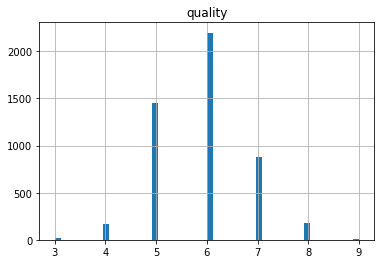

In [53]:
df.hist(column='quality', bins=50)

In [54]:
def iqr_outliers(df):
    out=[]
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    return out

In [55]:
count = 0
for name in list(df.iloc[:, :-1]):
    print(name)
    outliers = iqr_outliers(df[name])
    print(outliers)
    count += len(outliers)
print('Total: ', count)

fixed acidity
[9.8, 9.8, 10.2, 9.1, 10.0, 9.2, 9.2, 9.0, 9.1, 9.2, 10.3, 9.4, 9.2, 9.8, 9.6, 9.2, 9.0, 9.3, 9.2, 9.1, 8.9, 9.8, 8.9, 9.2, 9.7, 9.4, 10.3, 9.6, 9.0, 9.7, 9.2, 9.4, 9.6, 9.2, 9.0, 9.2, 10.7, 10.7, 9.0, 9.2, 9.8, 9.2, 14.2, 8.9, 8.9, 9.1, 9.1, 9.8, 9.0, 9.3, 8.9, 9.0, 9.0, 8.9, 9.0, 9.3, 9.2, 9.6, 9.4, 9.4, 10.0, 8.9, 8.9, 10.0, 9.2, 9.2, 9.2, 9.9, 9.5, 9.0, 9.0, 8.9, 9.5, 11.8, 9.4, 9.1, 9.8, 9.9, 9.2, 8.9, 9.2, 9.4, 9.4, 9.4, 4.6, 8.9, 9.4, 9.2, 9.2, 9.8, 9.0, 9.0, 9.0, 8.9, 8.9, 4.5, 9.2, 9.6, 4.2, 9.7, 9.7, 9.0, 4.2, 9.4, 8.9, 8.9, 8.9, 4.7, 4.7, 3.8, 4.4, 4.7, 9.0, 9.0, 4.7, 4.4, 3.9, 4.7, 4.4]
volatile acidity
[0.66, 0.66, 0.67, 0.54, 0.595, 0.67, 0.53, 0.54, 0.57, 0.685, 0.495, 0.64, 0.52, 0.58, 0.585, 0.59, 0.6, 0.58, 0.59, 0.55, 0.905, 0.55, 0.49, 0.55, 0.52, 0.6, 0.55, 0.51, 0.62, 0.51, 0.56, 0.57, 0.67, 0.5, 0.56, 0.56, 0.655, 0.595, 0.705, 0.52, 0.55, 0.6, 0.64, 0.68, 0.49, 0.51, 0.55, 0.52, 0.5, 0.55, 0.6, 0.61, 0.61, 0.61, 0.66, 0.57, 0.5, 0.5, 0.59, 0.58, 0.

<AxesSubplot:>

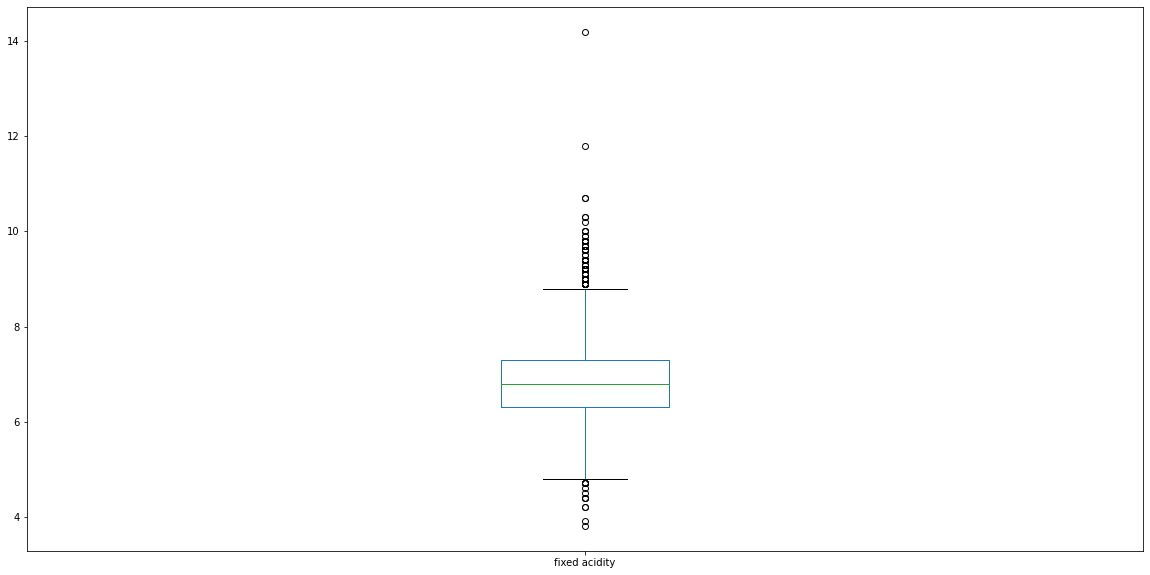

In [56]:
fig = plt.figure(figsize = (20,10))
df.boxplot(column=['fixed acidity'], grid=False)

#### Detect features and target

In [57]:
bins = (1, 4.5, 7.5, 10)
group_names = ['bad', 'good', 'high']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

In [58]:
df['quality'].value_counts()

good    4535
bad      183
high     181
Name: quality, dtype: int64

In [59]:
label_quality = LabelEncoder()
df['quality'] = label_quality.fit_transform(df['quality'])

array([[<AxesSubplot:title={'center':'quality'}>]], dtype=object)

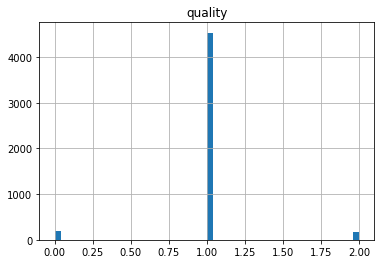

In [60]:
df.hist(column='quality', bins=50)

In [61]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print(X.shape)
print(y.shape)

(4899, 11)
(4899,)


#### Preprocessing

In [62]:
scaler = RobustScaler()
X = scaler.fit_transform(X)

(12407, 11)
(12407,)


<AxesSubplot:>

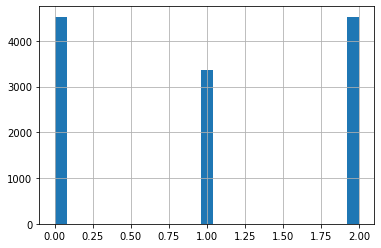

In [63]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Balance dataset
over = SMOTEENN()

X, y = over.fit_resample(X, y)
print(X.shape)
print(y.shape)
y.hist(bins=25)

In [64]:
balanced_scaled_df = pd.DataFrame(X, columns = [name for name in list(df.iloc[:, :-1])])

In [65]:
count = 0
for name in list(df.iloc[:, :-1]):
    print(name)
    outliers = iqr_outliers(balanced_scaled_df[name])
    count += len(outliers)
print('Total: ', count)

fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
Total:  3707


### Feature selection 

#### By correlation 

<AxesSubplot:>

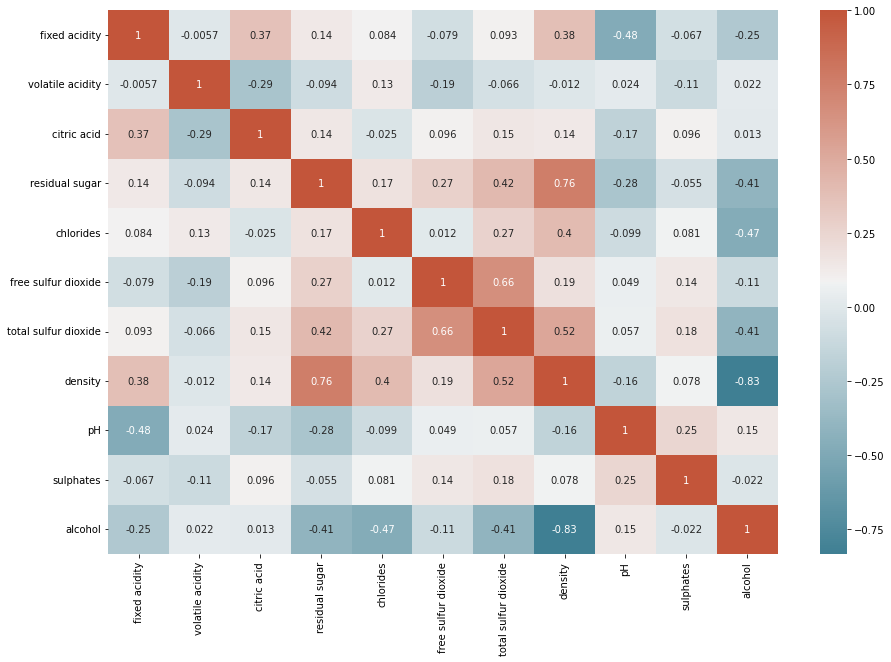

In [66]:
corr = balanced_scaled_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [67]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if abs(corr.iloc[i, j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = balanced_scaled_df.columns[columns]
print(selected_columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates'],
      dtype='object')


In [68]:
reduced_df = balanced_scaled_df[selected_columns]

In [69]:
reduced_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
0,-0.6,1.727273,-0.500000,-0.097561,1.428571,1.260870,1.220339,0.059361,0.473684,0.357143
1,3.0,0.909091,1.166667,0.646341,-0.357143,-1.304348,-0.864407,0.424658,-1.526316,-1.214286
2,-1.3,2.045455,-2.666667,-0.451220,1.571429,-1.130435,-0.525424,0.059361,2.368421,-0.500000
3,-0.4,3.045455,-1.500000,0.000000,1.071429,-0.826087,-0.627119,0.310502,1.052632,-0.785714
4,0.8,2.000000,0.416667,-0.536585,-0.428571,-1.304348,-0.576271,-0.808219,-0.789474,-0.571429


In [70]:
X = reduced_df.iloc[:, :].values
print(X.shape)

(12407, 10)


#### Split data in train and test 

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [73]:
X_test[:5]

array([[-0.1       ,  0.18181818,  0.16666667,  0.45121951,  0.35714286,
        -0.08695652, -0.38983051,  0.18493151,  0.36842105,  0.5       ],
       [ 0.12871704,  0.99981468, -0.01188049,  0.52637745,  0.15304042,
        -0.05569804,  0.03628013, -0.16155622, -0.42866339, -0.98981672],
       [-0.6       ,  1.        , -0.66666667,  0.1097561 , -0.78571429,
        -0.65217391, -0.81355932, -1.00456621, -0.73684211, -1.5       ],
       [ 0.0694087 , -0.11058657, -1.14490145, -0.3832403 ,  0.21428571,
        -1.12102382, -0.99014416,  0.14880682,  0.8739277 , -0.22387079],
       [ 0.3       , -0.54545455, -0.08333333,  0.26829268,  0.71428571,
        -0.08695652,  1.30508475,  0.48630137,  0.68421053,  0.85714286]])

In [74]:
y_test[:5]

7193     1
8266     2
10292    2
2008     0
6367     1
Name: quality, dtype: int64

In [75]:
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

Train set: (9925, 10) (9925,)
Test set: (2482, 10) (2482,)


#### Util functions 

In [76]:
all_cross = {}

def print_cros_val_score(model, model_name=''):
    scores = cross_val_score(model, X, y, cv=5, n_jobs = -1)
    print(scores.mean())
    if model_name != '':
        all_cross[model_name]['Cross value mean'] = scores.mean()

In [77]:
all_metrics = {}
def print_metrics(y_pred, model_name=''):

    confusion_mat = metrics.confusion_matrix(y_test, y_pred)
    print("Confusion matrix is : ", confusion_mat)
    
    acc =  metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    print("Recall_score is :", recall)
    
    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    print("Precision Score is : ", precision)
    
    f1 = 2 * (recall * precision) / (recall + precision)
    print("F1 score is: ", f1)
    
    jacc = metrics.jaccard_score(y_test, y_pred, average='weighted')
    print("Jaccard: ", jacc)
    
    all_metrics[model_name] = {}
    all_metrics[model_name]['Accuracy'] = acc
    all_metrics[model_name]['Recall_score'] = recall
    all_metrics[model_name]['Precision'] = precision
    all_metrics[model_name]['F1'] = f1
    all_metrics[model_name]['Jaccard'] = jacc
    
    

In [85]:
test_cases = [
    [-0.1       ,  0.18181818,  0.16666667,  0.45121951,  0.35714286,
        -0.08695652, -0.38983051,  0.18493151,  0.36842105,  0.5       ],
       [ 0.12871704,  0.99981468, -0.01188049,  0.52637745,  0.15304042,
        -0.05569804,  0.03628013, -0.16155622, -0.42866339, -0.98981672],
       [-0.6       ,  1.        , -0.66666667,  0.1097561 , -0.78571429,
        -0.65217391, -0.81355932, -1.00456621, -0.73684211, -1.5       ],
]
expected = [1, 1, 2]

def test_prediction(model):
    y_prediction_test = model.predict(test_cases)
    print("Predicted: ", y_prediction_test)
    print("Expected: ", expected)

In [79]:
def get_best_params(model, param):
    grid_svc = GridSearchCV(model, param_grid=param, scoring='accuracy', cv=10)
    grid_svc.fit(X_train, y_train)
    best = grid_svc.best_params_
    return best

# K nearest neighbor (KNN)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
param = {
    'n_neighbors': [1, 2, 5, 8, 12, 20, 50],
}
get_best_params(KNeighborsClassifier(), param)

{'n_neighbors': 1}

In [80]:
from sklearn.neighbors import KNeighborsClassifier
k = 1
neigh = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
neigh.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=1)

In [81]:
print_cros_val_score(neigh)

0.9694549161865471


In [82]:
y_pred = neigh.predict(X_test)

In [83]:
print_metrics(y_pred, 'KNN')

Confusion matrix is :  [[947   0   0]
 [  8 611   9]
 [  0   0 907]]
Accuracy: 0.9931506849315068
Recall_score is : 0.9931506849315068
Precision Score is :  0.9932133133176488
F1 score is:  0.9931819981372677
Jaccard:  0.9863639982491557


In [86]:
test_prediction(neigh)

Predicted:  [1 2 2]
Expected:  [1, 1, 2]


# SVM

In [40]:
from sklearn.svm import SVC

param = {
    'C': [1, 1.2],
    'gamma' :[0.9, 1.2]
}
get_best_params(SVC(), param)

{'C': 1.2, 'gamma': 1.2}

In [88]:
from sklearn.svm import SVC

svc = SVC(C=1.2, gamma=1.2, kernel='rbf')
svc.fit(X_train, y_train)

SVC(C=1.2, gamma=1.2)

In [42]:
print_cros_val_score(svc)

0.9924951188042511


In [90]:
y_pred = svc.predict(X_test)

In [91]:
print_metrics(y_pred, 'SVC')

Confusion matrix is :  [[934   2   0]
 [  1 644   4]
 [  0   0 894]]
Accuracy: 0.9971762807583703
Recall_score is : 0.9971762807583703
Precision Score is :  0.9971792900070692
F1 score is:  0.9971777853804494
Jaccard:  0.9943697153916334


In [89]:
test_prediction(svc)

Predicted:  [1 2 2]
Expected:  [1, 1, 2]


In [47]:
from sklearn.svm import NuSVC

param = {
    'nu': [0.2, 0.5, 0.8],
    'gamma' :[0.1, 1, 1.5]
}
get_best_params(NuSVC(), param)

{'gamma': 1.5, 'nu': 0.2}

In [90]:
from sklearn.svm import NuSVC

nuSvc = NuSVC(gamma=1.5, nu=0.2)
nuSvc.fit(X_train, y_train)

NuSVC(gamma=1.5, nu=0.2)

In [49]:
print_cros_val_score(nuSvc)

0.9919300168225036


In [92]:
y_pred = nuSvc.predict(X_test)

In [93]:
print_metrics(y_pred, 'NuSVC')

Confusion matrix is :  [[930   6   0]
 [  0 645   4]
 [  0   0 894]]
Accuracy: 0.9959661153691004
Recall_score is : 0.9959661153691004
Precision Score is :  0.9959807384234213
F1 score is:  0.9959734268425864
Jaccard:  0.9919763696754227


In [91]:
test_prediction(nuSvc)

Predicted:  [1 2 2]
Expected:  [1, 1, 2]


# Bagging

## Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

param = {
    'n_estimators': [50, 100, 200],
    'max_features' :['sqrt', 'log2', None]
}
get_best_params(RandomForestClassifier(), param)

{'max_features': 'sqrt', 'n_estimators': 200}

In [92]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = 200
max_features = 'sqrt'
rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=200)

In [55]:
print_cros_val_score(rf)

0.9659430418094723


In [94]:
y_pred = rf.predict(X_test)

In [95]:
print_metrics(y_pred, 'RandomForestClassifier')

Confusion matrix is :  [[925  11   0]
 [ 20 610  19]
 [  2   1 891]]
Accuracy: 0.9786204114562324
Recall_score is : 0.9786204114562324
Precision Score is :  0.9786481280496653
F1 score is:  0.9786342695567035
Jaccard:  0.9581046914196942


In [93]:
test_prediction(rf)

Predicted:  [1 2 2]
Expected:  [1, 1, 2]


## Extra Trees 

In [59]:
from sklearn.ensemble import ExtraTreesClassifier

param = {
    'n_estimators': [50, 100, 200],
    'max_features' :['sqrt', 'log2', None]
}
get_best_params(ExtraTreesClassifier(), param)

{'max_features': 'log2', 'n_estimators': 200}

In [94]:
from sklearn.ensemble import ExtraTreesClassifier


n_estimators = 200
max_features = 'log2'
et = ExtraTreesClassifier(n_estimators=n_estimators, max_features=max_features, random_state=seed)
et.fit(X_train, y_train)

ExtraTreesClassifier(max_features='log2', n_estimators=200, random_state=33)

In [61]:
print_cros_val_score(et)

0.9763538175883231


In [96]:
y_pred = et.predict(X_test)

In [97]:
print_metrics(y_pred, 'ExtraTreesClassifier')

Confusion matrix is :  [[931   5   0]
 [ 12 625  12]
 [  0   0 894]]
Accuracy: 0.9883017345703913
Recall_score is : 0.9883017345703913
Precision Score is :  0.988340953674494
F1 score is:  0.9883213437333642
Jaccard:  0.9768438252557464


In [95]:
test_prediction(et)

Predicted:  [1 2 2]
Expected:  [1, 1, 2]


# Boosting

## AdaBoost 

In [67]:
from sklearn.ensemble import AdaBoostClassifier


param = {
    'n_estimators': [50, 100, 200, 500],
}
get_best_params(AdaBoostClassifier(), param)

{'n_estimators': 200}

In [96]:
from sklearn.ensemble import AdaBoostClassifier


n_estimators = 500
ab = AdaBoostClassifier(n_estimators=n_estimators, random_state=7)
ab.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=500, random_state=7)

In [71]:
print_cros_val_score(ab)

0.7810511932191668


In [98]:
y_pred = ab.predict(X_test)

In [99]:
print_metrics(y_pred, 'AdaBoostClassifier')

Confusion matrix is :  [[777 150   9]
 [167 369 113]
 [ 12  96 786]]
Accuracy: 0.7793465106897943
Recall_score is : 0.7793465106897943
Precision Score is :  0.7761298213566759
F1 score is:  0.7777348400034003
Jaccard:  0.6500429729556843


In [97]:
test_prediction(ab)

Predicted:  [1 2 2]
Expected:  [1, 1, 2]


# Gradient Boosting

In [76]:
from sklearn.ensemble import GradientBoostingClassifier


param = {
    'n_estimators': [100, 500],
    'learning_rate': [0.1, 0.4, 0.7],
    'max_features' :['sqrt', 'log2', None],
}
get_best_params(GradientBoostingClassifier(), param)

{'learning_rate': 0.7, 'max_features': 'log2', 'n_estimators': 500}

In [98]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators=500
learning_rate=0.7
max_features='log2'
gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_features=max_features, random_state=seed)
gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.7, max_features='log2',
                           n_estimators=500, random_state=33)

In [78]:
print_cros_val_score(gb)

0.9708670833386239


In [100]:
y_pred = gb.predict(X_test)

In [101]:
print_metrics(y_pred, 'GradientBoostingClassifier')

Confusion matrix is :  [[931   5   0]
 [ 15 624  10]
 [  1   6 887]]
Accuracy: 0.9850746268656716
Recall_score is : 0.9850746268656716
Precision Score is :  0.9850652582427643
F1 score is:  0.9850699425319425
Jaccard:  0.9706095176578523


In [99]:
test_prediction(gb)

Predicted:  [1 2 2]
Expected:  [1, 1, 2]


In [105]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df['Best'] = metrics_df.idxmax(axis=1)
metrics_df

,KNN,SVC,NuSVC,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,Best
Accuracy,0.993949,0.997176,0.995966,0.978620,0.988302,0.779347,0.985075,SVC
Recall_score,0.993949,0.997176,0.995966,0.978620,0.988302,0.779347,0.985075,SVC
Precision,0.993999,0.997179,0.995981,0.978648,0.988341,0.776130,0.985065,SVC
F1,0.993974,0.997178,0.995973,0.978634,0.988321,0.777735,0.985070,SVC
Jaccard,0.987948,0.994370,0.991976,0.958105,0.976844,0.650043,0.970610,SVC
